In [1]:
import pandas as pd
import numpy as np

import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score

from eda_helpers import normality_check
from stat_inference_helpers import custom_corr, custom_anova, show_outliers_importance, evaluate_model, distance_betw_2points
from statsmodels.stats.outliers_influence import variance_inflation_factor

/Users/nadiiaduiunova/miniconda3/envs/to_remove/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


**1. Start from the Summary coming from the Exploratory Data Analysis (EDA)**

**Summary:**
 - Target: `Price` numerical continuous variable;
 - There are 6 features: 4 continuous, 2 text;
 - There are 3 missing values in target variable;
 - There are no missing values in features;
 - `Price`, `Area` and `Room` have right-skewed distribution and 56, 33, 62 outliers respectively. However if we look closer to these outliers, we'll see that all of them are just big (and thus expencive) houses. These values will not be considered as outliers;
 - There are 2 outiers in `Longitude`, that are much lower than the mean;
 - Outliers of `Latitude` create a cluster togeter with other points and will not be considered as outliers.
 - There is one point, which is an outlier niether for longitude, not for latitude, but when plotting coordinates, we see that it is far from the main distribution of points. It will be considered an outlier;
 - Most values of both text features (`Address` and `Zip`) are unique, thus not informative for prediction;
 - When removing letters from `Zip` code, there are 70 unique values, which represent areas of the city. The assumption is they are more generalized, than original format of zip code.
 

**2. Begin to process the dataset accordingly, e.g., by dealing with missing values, feature engineering and transformation;**

In [4]:
data = pd.read_csv("data/data_train.csv")

data_info = pd.read_parquet("./data/data_info.parquet")
print(f'o Shape of train dataset: {data.shape}')
display(data.sample(3))
print('o Data information')
display(data_info.transpose())
print(f'o Number of duplicate rows that will be removed: {data.duplicated().sum()}')
print(f'o Data type in Dataset: {data_info["data_type"].unique()}')
print(f"o Columns: {data_info.index.tolist()}")

o Shape of train dataset: (739, 7)


,Address,Zip,Price,Area,Room,Lon,Lat
216,"Wolbrantskerkweg 66 E, Amsterdam",1069 DA,525000.0,112,5,4.797330,52.356512
687,"Keizersgracht 171 F, Amsterdam",1016 DP,1625000.0,199,6,4.885830,52.374742
50,"Termietergouw 6 A, Amsterdam",1027 AD,899000.0,128,5,4.960756,52.409584


o Data information


index,Price,Address,Zip,Area,Room,Lon,Lat
data_type,continuous,text,text,continuous,descrete,continuous,continuous
missing values,3,0,0,0,0,0,0
distribution,right_skewed,not applicable,not applicable,right_skewed,right_skewed,normal,heavy_tailed
n outliers,0,0,0,1,0,2,0


o Number of duplicate rows that will be removed: 1
o Data type in Dataset: ['continuous' 'text' 'descrete']
o Columns: ['Price', 'Address', 'Zip', 'Area', 'Room', 'Lon', 'Lat']


In [5]:
#remove duplicates:
data = data.drop_duplicates()

# remove Longitude outliers (Lon < 4.7)
data.drop(data[data['Lon']< 4.7].index, inplace=True)

# reset indexes after removing rows
data = data.reset_index()
data = data.drop(columns=['index'])
data.tail()


,Address,Zip,Price,Area,Room,Lon,Lat
732,"Cliostraat 23 HS, Amsterdam",1077 KB,1025000.0,135,4,4.875881,52.347368
733,"Prinsenstraat 4, Amsterdam",1015 DC,915000.0,88,5,4.887412,52.377742
734,"Revaleiland 383, Amsterdam",1014 ZG,690000.0,100,3,4.881116,52.393955
735,"Linnaeusstraat 243 1., Amsterdam",1093 ER,450000.0,60,4,4.928173,52.355788
736,"Van Gentstraat 6 1, Amsterdam",1055 PE,425000.0,69,4,4.851176,52.383021


**3. For supervised learning, study the relationship between features, a.k.a. independent variables (IV), with the target, a.k.a. the dependent variable (DV).**


- **a.** Study the [correlation](https://www.statisticshowto.com/probability-and-statistics/correlation-analysis/) for both **Discrete** and **Numerical** features.
- **b.** Apply [ANOVA](https://www.statisticshowto.com/probability-and-statistics/hypothesis-testing/anova/#OneWayANOVA) between **Nominal** feature and **Numerical** target;
- **c.** If necessary, transform or construct new features and re-apply the same statistical test;

**!!!** whenever possible, plot the variables to assess whether the results coming from the statistical test are driven by outliers or imbalanced facets;

💁‍♀️ Look closely at the relationship between the dependent variable, i.e., the target and the independent variables, i.e., the features, as they will provide an insight into candidate predictors.

👷 Transform and/or construct new features and apply appropriate statistical tests.

**0.** Before applying tests it makes sence to **handle the missing values**:

In [6]:
missing_data = data[data.isna().any(axis=1)]
missing_data

,Address,Zip,Price,Area,Room,Lon,Lat
110,"Zeeburgerkade 760, Amsterdam",1019 HT,NaN,107,3,4.945022,52.369244
417,"Suikerplein 16, Amsterdam",1013 CK,NaN,81,3,4.880976,52.389623
527,"Haarlemmerweg 705, Amsterdam",1067 HP,NaN,366,12,4.787874,52.383877


To determine missing prices it is possible to count average price per square meter (sqm) in the neighbourhood and then multiply it by the house's area:

In [7]:
zips = []

for i in range(missing_data.shape[0]):
    zips.append(list(missing_data['Zip'])[i][:4])

data['Price per sqm'] = data['Price'] / data['Area']

for i in zips:

    #create dataframe with all houses in the neighbourhood
    data_copy = data.loc[data['Zip'].str.contains(i)]

    # get avg price per sqm in the neighbourhood
    mean = data_copy.loc[(data_copy['Zip'].str.contains(i)), 'Price per sqm'].mean()

    #set this value to the row with missing price
    data.loc[(data['Price'].isna()) & (data['Zip'].str.contains(i)), 'Price per sqm'] = mean
    print(f'o Avg Price per sqm in the neighbourhood: {mean}')
    target_row = data.loc[(data['Price'].isna()) & (data['Zip'].str.contains(i))]
    print(f'o Row with the imputed value: {target_row.index[0]}')

    # get area value of the row with missing price
    area = target_row['Area']

    # set missing price by multiplying average price by size of the house in sqm
    data.loc[(data['Price'].isna()) & (data['Zip'].str.contains(i)), 'Price'] = mean * area
    display(data.loc[data['Zip'].str.contains(i)])


o Avg Price per sqm in the neighbourhood: 6211.207018260803
o Row with the imputed value: 110


,Address,Zip,Price,Area,Room,Lon,Lat,Price per sqm
74,"Borneokade 70, Amsterdam",1019 AW,1.750000e+06,246,8,4.909819,52.368653,7113.821138
110,"Zeeburgerkade 760, Amsterdam",1019 HT,6.645992e+05,107,3,4.945022,52.369244,6211.207018
119,"Borneolaan 342, Amsterdam",1019 KL,4.500000e+05,85,3,4.937516,52.370995,5294.117647
148,"Javakade 144, Amsterdam",1019 RW,7.500000e+05,118,4,4.930455,52.377871,6355.932203
199,"Levantplein 9, Amsterdam",1019 MA,1.450000e+06,273,5,4.942112,52.376819,5311.355311
253,"Nieuwevaartweg, Amsterdam",1019 AL,6.500000e+05,87,4,4.954376,52.367982,7471.264368
262,"Panamalaan 84, Amsterdam",1019 AZ,6.950000e+05,107,4,4.934082,52.371077,6495.327103
288,"Levantkade 170, Amsterdam",1019 BG,5.490000e+05,91,5,4.943456,52.376191,6032.967033
360,"KNSM-laan 609, Amsterdam",1019 LD,5.390000e+05,88,3,4.942972,52.377442,6125.000000
375,"KNSM-laan 479 PP, Amsterdam",1019 LG,5.850000e+05,87,3,4.941549,52.377347,6724.137931


o Avg Price per sqm in the neighbourhood: 7384.105771224381
o Row with the imputed value: 417


,Address,Zip,Price,Area,Room,Lon,Lat,Price per sqm
43,"Droogbak 5 B, Amsterdam",1013 GE,5.950000e+05,78,3,4.893924,52.379828,7628.205128
77,"Oostzaanstraat 255, Amsterdam",1013 WJ,7.250000e+05,118,4,4.872520,52.392217,6144.067797
89,"Spaarndammerstraat 62 1, Amsterdam",1013 SZ,3.450000e+05,48,2,4.880745,52.388005,7187.500000
167,"Van Noordtkade 140, Amsterdam",1013 CA,3.350000e+05,61,2,4.881952,52.389025,5491.803279
184,"Westerdoksdijk 375, Amsterdam",1013 AD,5.250000e+05,63,3,4.892914,52.384794,8333.333333
274,"Haparandaweg 932 A, Amsterdam",1013 BD,5.000000e+05,76,3,4.878134,52.395229,6578.947368
340,"Haarlemmerdijk 178 C, Amsterdam",1013 JK,3.750000e+05,44,2,4.884769,52.384121,8522.727273
352,"Droogbak 6 B, Amsterdam",1013 GE,5.750000e+05,80,3,4.893865,52.379863,7187.500000
361,"Adrichemstraat 15, Amsterdam",1013 DR,4.500000e+05,73,3,4.877698,52.388468,6164.383562
417,"Suikerplein 16, Amsterdam",1013 CK,5.981126e+05,81,3,4.880976,52.389623,7384.105771


o Avg Price per sqm in the neighbourhood: 4341.84676704018
o Row with the imputed value: 527


,Address,Zip,Price,Area,Room,Lon,Lat,Price per sqm
3,"De Bazelhof 24, Amsterdam",1067 LZ,4.000000e+05,107,6,4.795810,52.376916,3738.317757
21,"Pieter van der Werfstraat 127, Amsterdam",1067 EM,3.500000e+05,87,3,4.802688,52.382381,4022.988506
53,"Teldershof 57, Amsterdam",1067 ML,3.500000e+05,88,3,4.800286,52.380052,3977.272727
138,"Hendrik Bulthuisstraat 8, Amsterdam",1067 SC,3.450000e+05,69,4,4.795948,52.374337,5000.000000
139,"J.G. Suurhoffstraat 123, Amsterdam",1067 VR,4.250000e+05,102,4,4.789341,52.380775,4166.666667
154,"Sam van Houtenstraat 191 C, Amsterdam",1067 JG,3.750000e+05,94,4,4.800745,52.379133,3989.361702
192,"Aalbersestraat 232, Amsterdam",1067 GM,2.950000e+05,65,4,4.798255,52.378644,4538.461538
330,"Jan van Duivenvoordestraat 85 2, Amsterdam",1067 MT,3.500000e+05,92,3,4.802582,52.379007,3804.347826
338,"Kruisherenpad 7, Amsterdam",1067 DZ,4.400000e+05,115,6,4.802015,52.380829,3826.086957
351,"Gerda Brautigamstraat 37, Amsterdam",1067 VM,5.450000e+05,110,4,4.789083,52.379219,4954.545455


Add info about 'Price per sqm'

In [8]:
data_info.loc['Price per sqm', 'data_type'] = 'continuous'
data_info.loc['Price per sqm', 'missing values'] = 0
normality_check(data, data_info, ['Price per sqm'])
data_info

,data_type,missing values,distribution,n outliers
index,,,,
Price,continuous,3.0,right_skewed,0.0
Address,text,0.0,not applicable,0.0
Zip,text,0.0,not applicable,0.0
Area,continuous,0.0,right_skewed,1.0
Room,descrete,0.0,right_skewed,0.0
Lon,continuous,0.0,normal,2.0
Lat,continuous,0.0,heavy_tailed,0.0
Price per sqm,continuous,0.0,not normal,NaN


Because the distribution is not normal, let's discover it with a plot:

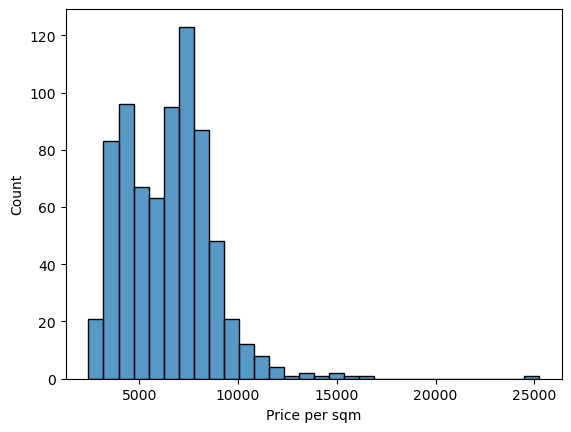

In [9]:
# plot 'Price per sqm' distribution as a histplot
plot = sns.histplot(x = data['Price per sqm'], bins = 30)

**Distribution is right-skewed**

In [10]:
data_info.loc['Price per sqm', 'distribution'] = 'right_skewed'

**Check outliers** of Price per sqm and if they are impactful by comparing the correlation with and without them:

o 9 datapoints with Price per sqm > 12649.031296572282


,Address,Zip,Price,Area,Room,Lon,Lat,Price per sqm
22,"Pieter Cornelisz. Hooftstraat 169 B, Amsterdam",1071 BW,1695000.0,117,3,4.876144,52.358928,14487.179487
149,"Zocherstraat 23 X, Amsterdam",1054 LR,1200000.0,81,3,4.858004,52.357400,14814.814815
162,"Prins Hendrikkade 512, Amsterdam",1011 TE,389000.0,30,2,4.906059,52.374085,12966.666667
277,"Keizersgracht 544, Amsterdam",1017 EL,5950000.0,394,10,4.887378,52.365078,15101.522843
418,"Dam 5 V, Amsterdam",1012 JS,4495000.0,178,5,4.894290,52.373106,25252.808989
554,"Leonard Bernsteinstraat 96 A, Amsterdam",1082 MR,1750000.0,130,3,4.872151,52.336348,13461.538462
587,"Amstel 102, Amsterdam",1017 AD,2325000.0,150,6,4.896842,52.366965,15500.000000
589,"Huidekoperstraat 24 F, Amsterdam",1017 ZM,2475000.0,183,4,4.897473,52.358943,13524.590164
644,"Nieuwe Keizersgracht 570 L, Amsterdam",1018 VG,1050000.0,63,3,4.908850,52.365524,16666.666667


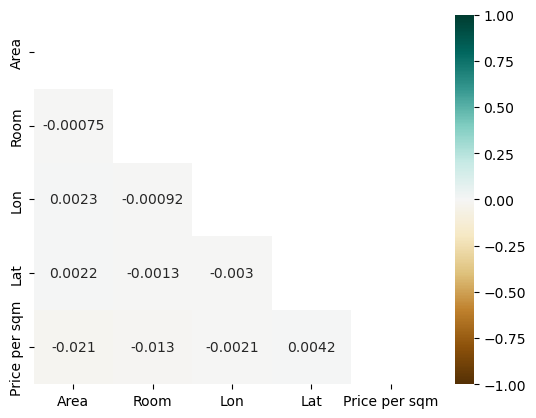

In [11]:
show_outliers_importance(data, data_info, 'Price per sqm', ['Area', 'Room', 'Lon', 'Lat'])

The biggest delta is just 2%, so we can make a conclusion that outliers here are not important.

In [12]:
data_info.loc['Price per sqm', 'n outliers'] = 0
data_info

,data_type,missing values,distribution,n outliers
index,,,,
Price,continuous,3.0,right_skewed,0.0
Address,text,0.0,not applicable,0.0
Zip,text,0.0,not applicable,0.0
Area,continuous,0.0,right_skewed,1.0
Room,descrete,0.0,right_skewed,0.0
Lon,continuous,0.0,normal,2.0
Lat,continuous,0.0,heavy_tailed,0.0
Price per sqm,continuous,0.0,right_skewed,0.0


**a. Study correlations between numerical features:**

In [13]:
correlations_df, _ = custom_corr(data, data_info, data.columns)
correlations_df

,method,feature1,feature2,r-value,p-value,stat-sign,N
0,Spearman,Lon,Price,-0.025781,4.846616e-01,False,737
1,Spearman,Lon,Area,0.078756,3.253710e-02,True,737
2,Spearman,Lon,Room,0.014287,6.986006e-01,False,737
3,Spearman,Lon,Lat,-0.091303,1.315111e-02,True,737
4,Spearman,Lon,Price per sqm,-0.111327,2.473536e-03,True,737
5,Spearman,Price,Area,0.720851,3.896903e-119,True,737
6,Spearman,Price,Room,0.518670,5.467193e-52,True,737
7,Spearman,Price,Lat,0.062011,9.252604e-02,False,737
8,Spearman,Price,Price per sqm,0.437909,7.000172e-36,True,737
9,Spearman,Area,Room,0.773116,1.774729e-147,True,737


As we can see here, most of statistically signifficant correlations are between a feature and a target (in this case there are 2 targets: price and price per sqm). Longitude and Latitude have no impact on price, however both have impact on price per sqm. Also there is positive correlation between Area and Rooms which seems to be fair. This features might be transformed later.

**o** Let's plot **Area** and **Room** features vs. Price to see the character of dependancy:

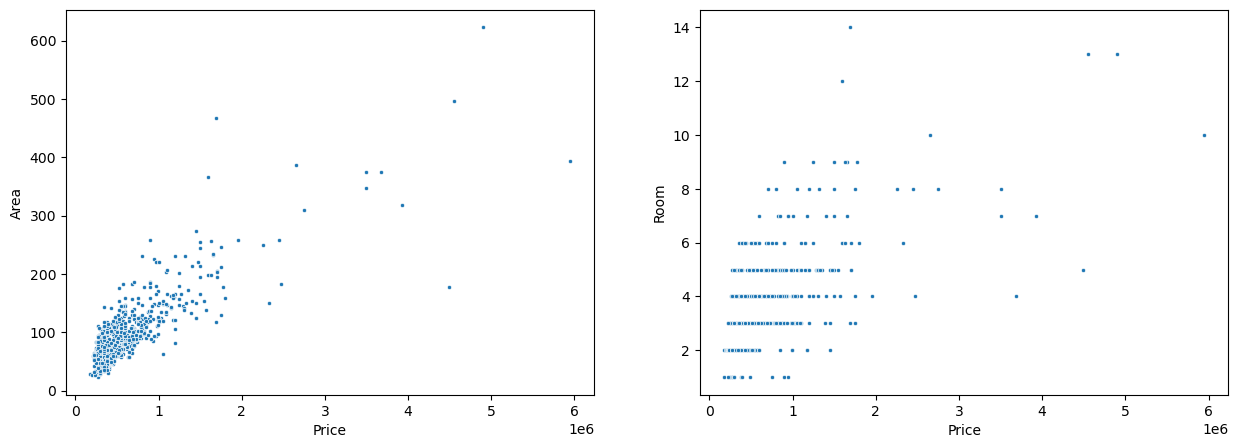

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for count, feature in enumerate(['Area', 'Room']):
    sns.scatterplot(data = data, x = 'Price', y = feature, marker='.', ax = axes.flatten()[count])

Room has no signifficant impact on Price. Area is positively correlated with the Price. Also, houses with the Price over 2M are mostly creating noise. It is better to normalize target and Area and plot again:

<Axes: xlabel='log_Price', ylabel='log_Area'>

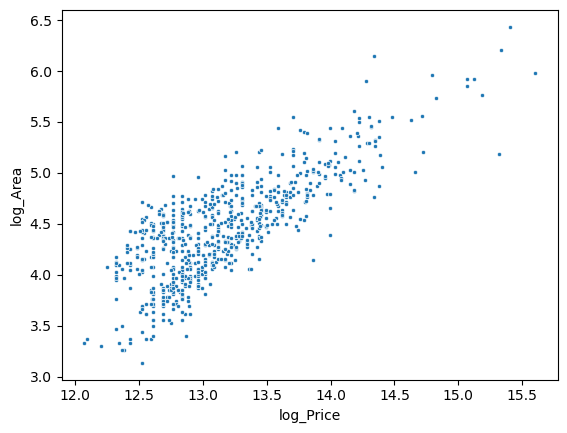

In [15]:
data['log_Price'] = np.log(data['Price'])
data_info.loc['log_Price', 'data_type'] = 'continuous'
data_info.loc['log_Price', 'missing values'] = 0

data['log_Area'] = np.log(data['Area'])
data_info.loc['log_Area', 'data_type'] = 'continuous'
data_info.loc['log_Area', 'missing values'] = 0

sns.scatterplot(data = data, x = 'log_Price', y = 'log_Area', marker='.')

Now the correlation is crlearly positive, containing some outliers though.
Let's try to discover if Area-Room ratio would work better than 2 separate features:

<Axes: xlabel='log_Price', ylabel='AR_ratio'>

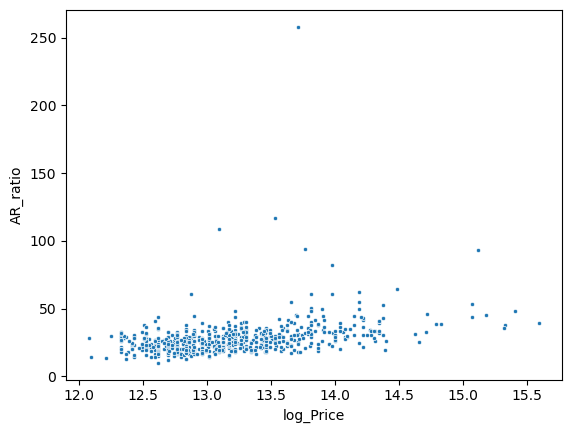

In [16]:
data['AR_ratio'] = data['Area'] / data['Room']
data_info.loc['AR_ratio', 'data_type'] = 'continuous'
data_info.loc['AR_ratio', 'missing values'] = 0

sns.scatterplot(data = data, x = 'log_Price', y = 'AR_ratio', marker='.')

Here is clearly an outlier at the top, but the others (around AR_ratio 50-150) are not clear. Let's apply custom `show_outliers_importance` function to see if it makes sence to remove outliers:

<Axes: xlabel='AR_ratio', ylabel='Count'>

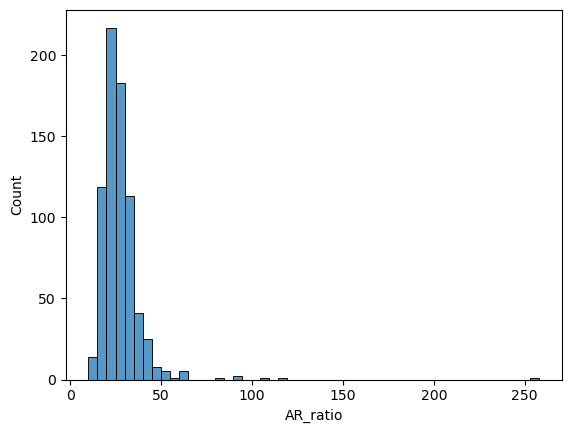

In [17]:
# but first we need info about the distribution of the feature
sns.histplot(x = data['AR_ratio'], bins = 50)

o 25 datapoints with AR_ratio > 44.75


,Address,Zip,Price,Area,Room,Lon,Lat,Price per sqm,log_Price,log_Area,AR_ratio
12,"Singel 318, Amsterdam",1016 AE,4900000.0,623,13,4.887869,52.371039,7865.168539,15.404746,6.434547,47.923077
27,"Herengracht 553 I, Amsterdam",1017 BW,995000.0,146,3,4.895233,52.365084,6815.068493,13.810498,4.983607,48.666667
85,"Sophialaan 45, Amsterdam",1075 BM,3500000.0,374,7,4.857608,52.352366,9358.288770,15.068274,5.924256,53.428571
104,"Ringdijk, Amsterdam",1097 AE,750000.0,117,1,4.927757,52.354173,6410.256410,13.527828,4.762174,117.000000
136,"Vondelstraat 51 hs, Amsterdam",1054 GJ,3925000.0,319,7,4.875471,52.361571,12304.075235,15.182877,5.765191,45.571429
183,"Willem Frederik Hermansstraat 169 PP, Amsterdam",1011 DG,999500.0,151,3,4.907627,52.376281,6619.205298,13.815010,5.017280,50.333333
199,"Levantplein 9, Amsterdam",1019 MA,1450000.0,273,5,4.942112,52.376819,5311.355311,14.187074,5.609472,54.600000
203,"Prinsengracht 483 A, Amsterdam",1016 HP,1750000.0,212,4,4.883097,52.369689,8254.716981,14.375126,5.356586,53.000000
269,"Cliostraat 14 A, Amsterdam",1077 KG,885000.0,136,3,4.876154,52.347558,6507.352941,13.693343,4.912655,45.333333
307,"Herengracht 12 C, Amsterdam",1015 BK,998000.0,121,2,4.891161,52.378843,8247.933884,13.813509,4.795791,60.500000


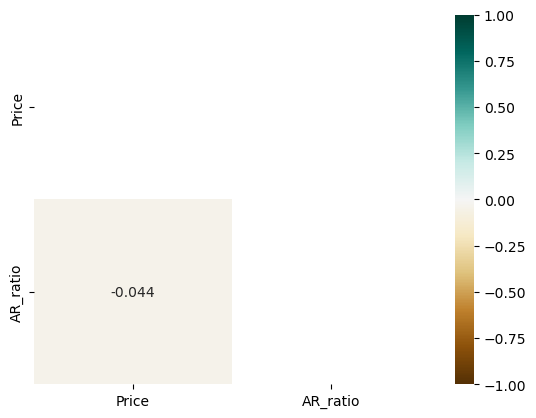

In [18]:
data_info.loc['AR_ratio', 'distribution'] = 'right_skewed'
show_outliers_importance(data, data_info, 'AR_ratio', ['Price'])

25 points is a lot! However, we can see that the delta is small and negative, which means that leverage points make some positive influence on correlation between feature and taget but don't drive it.

Let's now check the impact of AR_ratio feature on the target and compare it to Area and Room features to inderstand if it can possibly be an alternative:

In [19]:
summary, _ = custom_corr(data, data_info, ['log_Price', 'Area', 'Room', 'AR_ratio'])
summary

,method,feature1,feature2,r-value,p-value,stat-sign,N
0,Spearman,log_Price,Area,0.720851,3.896903e-119,True,737
1,Spearman,log_Price,Room,0.518670,5.467193e-52,True,737
2,Spearman,log_Price,AR_ratio,0.442435,1.126842e-36,True,737
3,Spearman,Area,Room,0.773116,1.774729e-147,True,737
4,Spearman,Area,AR_ratio,0.536184,4.343829e-56,True,737
5,Spearman,Room,AR_ratio,-0.048336,1.899427e-01,False,737



Even though we have investigated the new feature, it did not give us any decision-changing insights. The old feature - `Area` - still has the biggest impact on the target 
and as long as **`Area`, `Room` and `AR_ratio` features are correlated to each other**, we have to choose only 1 of them. At this point, this will be the `Area` feature.

In [20]:
data = data.drop(columns=['AR_ratio', 'Room'])

**o** Now let's discover `Lon` and `Lat` features. As the correlation analysis says, there is no dependency of `Price` on any of the two. Let's discover a plot of `Lat` vs `Lon` to see king of a city map of the house prices. 

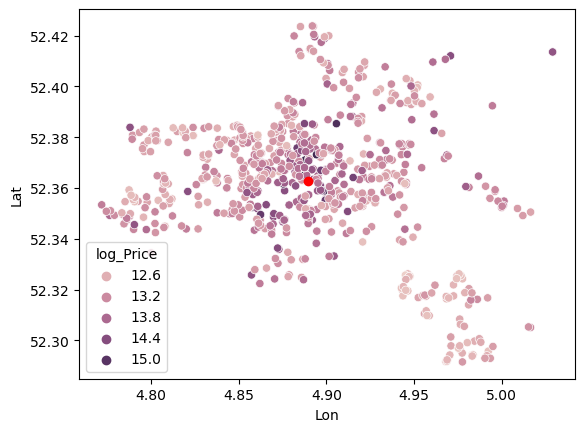

In [21]:
# plot longitude vs latitude and hue by price
sns.scatterplot(data = data, x = 'Lon', y = 'Lat', hue = 'log_Price')

center_lat = data['Lat'].mean()
center_lon = data['Lon'].mean()

plt.scatter(x = center_lon, y = center_lat, color = 'r', label = 'city center')

This plot is more informative: the darkest points are mostly located on the outskirts and **central** ones are more **expencive**. There are deffinetely some outliers in the top right corner of the plot.
Lat and Lon features can be used for engineering of an additional feature called 'Distance from city center'. Most popular formulas for calculating diistance between 2 points are Euclidean and Manhattan distance. There is also Haversine formula to count distance between 2 poins on the map having their latitude and longitude. Let's count 3 of them and define which correlates better with the Target:

**Haversine formula**:

a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)

c = 2 ⋅ atan2( √a, √(1−a) )

d = R ⋅ c

where φ is latitude, λ is longitude, R is earth’s radius (mean radius = 6,371km);

**Euclidean distance**:

d = √[(φ1 - φ2)² + (λ1 - λ2)²]

**Manhattan distance**:

d = |φ1 - φ2| + |λ1 - λ2|

In [22]:
# generate distance features
data = data.assign(
    **{
        "Euclidean_distance": lambda df: distance_betw_2points(
            df["Lat"], center_lat, df["Lon"], center_lon, method='Euclidean'
        ),
        "Manhattan_distance": lambda df: distance_betw_2points(
            df["Lat"], center_lat, df["Lon"], center_lon, method='Manhattan'
        ),
        "Haversine_distance": lambda df: distance_betw_2points(
            df["Lat"], center_lat, df["Lon"], center_lon, method='Haversine'
        )
    }
)

data.head()

,Address,Zip,Price,Area,Lon,Lat,Price per sqm,log_Price,log_Area,Euclidean_distance,Manhattan_distance,Haversine_distance
0,"Billitonstraat 4 3, Amsterdam",1094 BC,385000.0,49,4.938408,52.365552,7857.142857,12.860999,3.891820,0.996296,0.051544,3325.501444
1,"Zuidelijke Wandelweg 151 PP, Amsterdam",1079 RK,930000.0,123,4.894206,52.338220,7560.975610,13.742940,4.812184,2.708329,0.029115,2747.606908
2,"Tweede Keucheniusstraat 8 3, Amsterdam",1051 VR,500000.0,70,4.869195,52.380747,7142.857143,13.122363,4.248495,2.021203,0.038423,2433.520067
3,"De Bazelhof 24, Amsterdam",1067 LZ,400000.0,107,4.795810,52.376916,3738.317757,12.899220,4.672829,2.399810,0.107977,6561.761428
4,"Bos en Lommerweg 360, Amsterdam",1061 DJ,475000.0,98,4.838520,52.379072,4846.938776,13.071070,4.584967,2.053571,0.067423,3915.516501


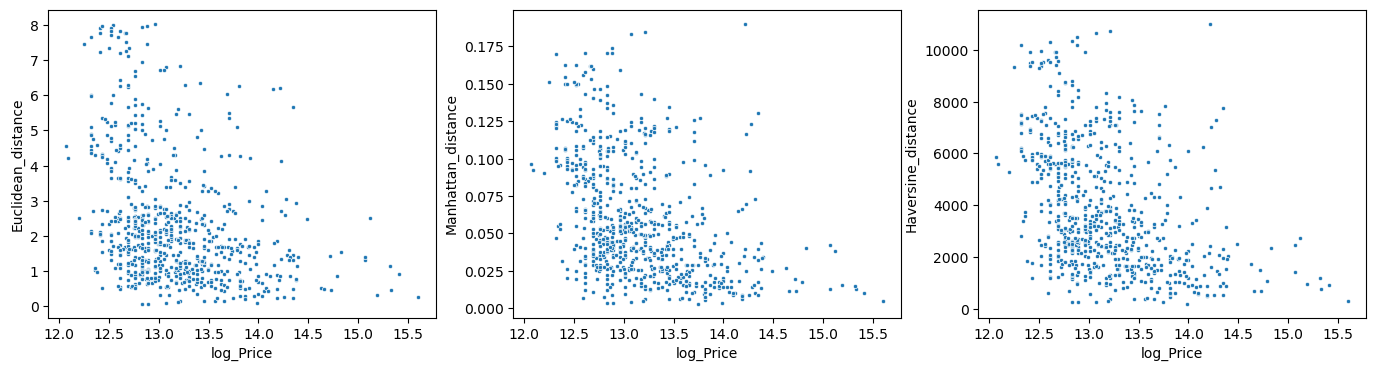

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(17, 4))
for count, feature in enumerate(data.columns[-3:]):
    sns.scatterplot(data = data, x = 'log_Price', y = feature, marker='.', ax = axes.flatten()[count])

There is negative correlation between `log_Price` and each `distance` feature. Let's update the correlation matrix with the new features and define which of 3 impacts the target the most:

In [24]:
# in order to get correlations, we have to know the type of distribution of new features

data_info.loc['Euclidean_distance', 'data_type'] = 'continuous'
data_info.loc['Manhattan_distance', 'data_type'] = 'continuous'
data_info.loc['Haversine_distance', 'data_type'] = 'continuous'
data_info.loc['Euclidean_distance', 'missing values'] = 0
data_info.loc['Manhattan_distance', 'missing values'] = 0
data_info.loc['Haversine_distance', 'missing values'] = 0

data_info = normality_check(data = data, data_info = data_info, features=data.columns[-3:], )

In [25]:
corr_distances, _ = custom_corr(data, data_info, ['log_Price', 'log_Area', 'Euclidean_distance', 'Manhattan_distance', 'Haversine_distance'])
corr_distances

,method,feature1,feature2,r-value,p-value,stat-sign,N
0,Spearman,log_Price,log_Area,0.720851,3.896903e-119,True,737
1,Spearman,log_Price,Euclidean_distance,-0.372705,1.057522e-25,True,737
2,Spearman,log_Price,Manhattan_distance,-0.462796,2.149184e-40,True,737
3,Spearman,log_Price,Haversine_distance,-0.447649,1.327883e-37,True,737
4,Spearman,log_Area,Euclidean_distance,0.081690,2.657917e-02,True,737
5,Spearman,log_Area,Manhattan_distance,0.072879,4.795577e-02,True,737
6,Spearman,log_Area,Haversine_distance,0.096961,8.438259e-03,True,737
7,Spearman,Euclidean_distance,Manhattan_distance,0.749230,1.184355e-133,True,737
8,Spearman,Euclidean_distance,Haversine_distance,0.818056,9.730789e-179,True,737
9,Spearman,Manhattan_distance,Haversine_distance,0.978618,0.000000e+00,True,737


Here we can see, that Manhattan_distance has the strongest correlation with the target. It is also correlated with the 'log_Area', however the signifficance is very close to the threshold of 0.05, so we can ignore this correltion. So at this point we **remove the following features:**
 - Euclidean_distance
 - Haversine_distance

In [26]:
data = data.drop(columns=['Euclidean_distance', 'Haversine_distance', 'Lon', 'Lat'])

Define the **outliers** of the new feature and check if they are impactful:

<Axes: xlabel='Manhattan_distance', ylabel='Count'>

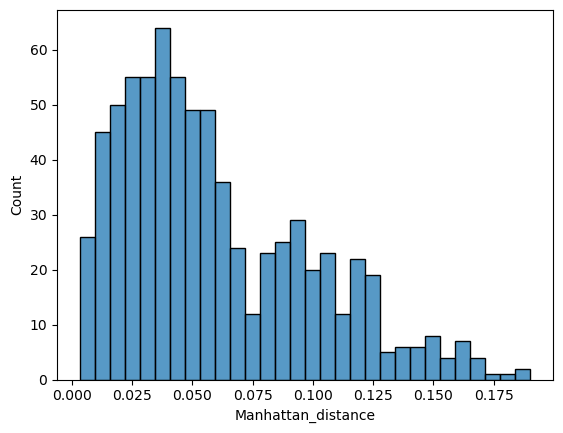

In [27]:
# because the distribution is not normal, lets plot it and manualy define the subtype, which is needed to find the outliers:

sns.histplot(x = data['Manhattan_distance'], bins = 30)

o 3 datapoints with Manhattan_distance > 0.17417034684342658


,Address,Zip,Price,Area,Price per sqm,log_Price,log_Area,Manhattan_distance
108,"Lange Stammerdijk 1 G, Amsterdam",1109 BK,549001.0,107,5130.850467,13.215856,4.672829,0.184576
377,"Leghornstraat 4, Amsterdam",1109 BW,475000.0,118,4025.423729,13.071070,4.770685,0.183209
422,"Dorpsstraat Holysloot 62, Amsterdam",1028 BE,1495000.0,214,6985.981308,14.217637,5.365976,0.190256


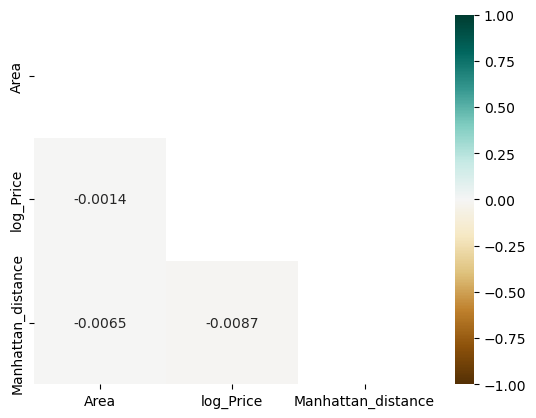

In [28]:
data_info.loc['Manhattan_distance', 'distribution'] = 'right_skewed'

show_outliers_importance(data, data_info, 'Manhattan_distance', ['Area', 'log_Price'])

The **outliers** again **do not have** signiffacant **impact** on the correlation and can stay.

**b. Study dependency of the target on the nominal features:**

As it was found out in EDA, the Address is unique for every datapoint, so it cannot be used as a predictor. However the Zip code has a pattern: The first two digits indicate a `City` and a `Region`, the third digit represents the `Location` and the fourth - `District`. The first letter indicates the `delivery area`, and the second letter indicates the subdivision of the delivery area. Consequently, the postcode and house number uniquely define a postal address. Let's us create several features based on subsection of the Zip code ([source](https://en.youbianku.com/Netherlands))

**Option 1**: Divide Zip to city, region, location, district, delivery area

In [29]:
# 1. create a copy of data to experiment with Zip
data1 = data.copy().drop(columns=['Address'])
data1.sample()

,Zip,Price,Area,Price per sqm,log_Price,log_Area,Manhattan_distance
63,1024 PN,325000.0,77,4220.779221,12.69158,4.343805,0.086984


In [30]:
# 2. transform Zip
data1['Zip city'] = np.nan
data1['Zip region'] = np.nan
data1['Zip location'] = np.nan
data1['Zip district'] = np.nan
data1['Delivery area'] = ''
for row in range(data1.shape[0]):
    data1.loc[row, 'Zip city'] = str(data1.loc[row, 'Zip'][0])
    data1.loc[row, 'Zip region'] = str(data1.loc[row, 'Zip'][1])
    data1.loc[row, 'Zip location'] = str(data1.loc[row, 'Zip'][2])
    data1.loc[row, 'Zip district'] = str(data1.loc[row, 'Zip'][3])
    data1.loc[row, 'Delivery area'] = str(data1.loc[row, 'Zip'][-2:])
data1.sample

display(data1['Zip city'].value_counts())
display(data1['Zip region'].value_counts())
display(data1['Zip location'].value_counts())
display(data1['Zip district'].value_counts())
display(data1['Delivery area'].value_counts())

Zip city
1    737
Name: count, dtype: int64

Zip region
0    668
1     69
Name: count, dtype: int64

Zip location
1    148
5    136
6    120
7     85
0     69
9     61
2     44
3     41
8     33
Name: count, dtype: int64

Zip district
7    114
5     94
3     87
2     86
4     81
1     73
8     73
6     66
9     48
0     15
Name: count, dtype: int64

Delivery area
EE    9
VG    7
XR    6
BG    6
AD    6
     ..
RR    1
GR    1
DL    1
AC    1
ZG    1
Name: count, Length: 322, dtype: int64

Zip city is always 1, so has no predictive power. Let's remove it:

In [31]:
data1 = data1.drop(columns=['Zip city'])

Let's now check if the rest of new features have impact on target. For this purpose custom function will be applied, which first checks if the variances of the variable groups are equal, and then performs either normal ANOVA or Welch ANOVA. It is also better to normalize the target by transforming it with logarithm function:

/Users/nadiiaduiunova/miniconda3/envs/to_remove/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/nadiiaduiunova/miniconda3/envs/to_remove/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/nadiiaduiunova/miniconda3/envs/to_remove/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/nadiiaduiunova/miniconda3/envs/to_remove/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  

,test-type,feature,group-var,f-value,p-value,stat-sign,variances
0,Welch ANOVA,Zip region,log_Price,277.171,0.00000,True,not_equal
1,Welch ANOVA,Zip location,log_Price,46.355,0.00000,True,not_equal
2,One way ANOVA,Zip district,log_Price,1.460,0.15864,False,equal
3,One way ANOVA,Delivery area,log_Price,0.711,0.99934,False,equal


/Users/nadiiaduiunova/miniconda3/envs/to_remove/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/nadiiaduiunova/miniconda3/envs/to_remove/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/nadiiaduiunova/miniconda3/envs/to_remove/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/nadiiaduiunova/miniconda3/envs/to_remove/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  

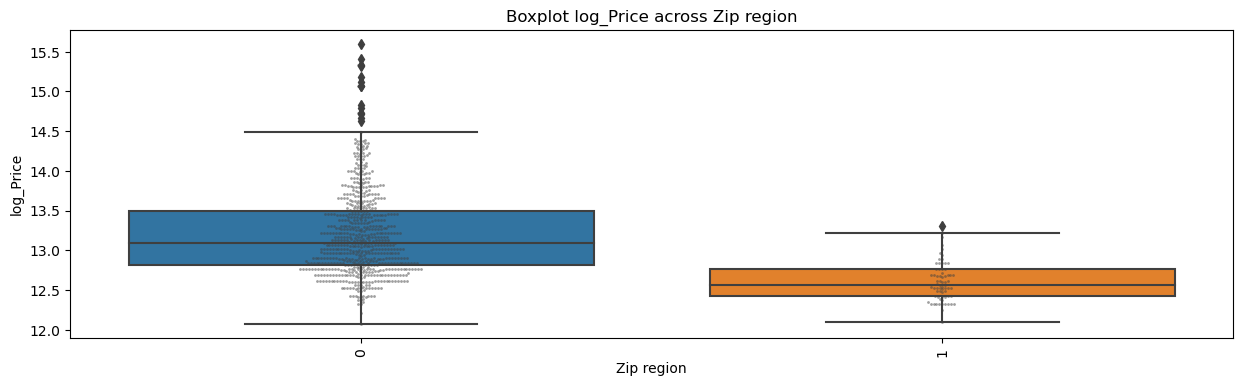

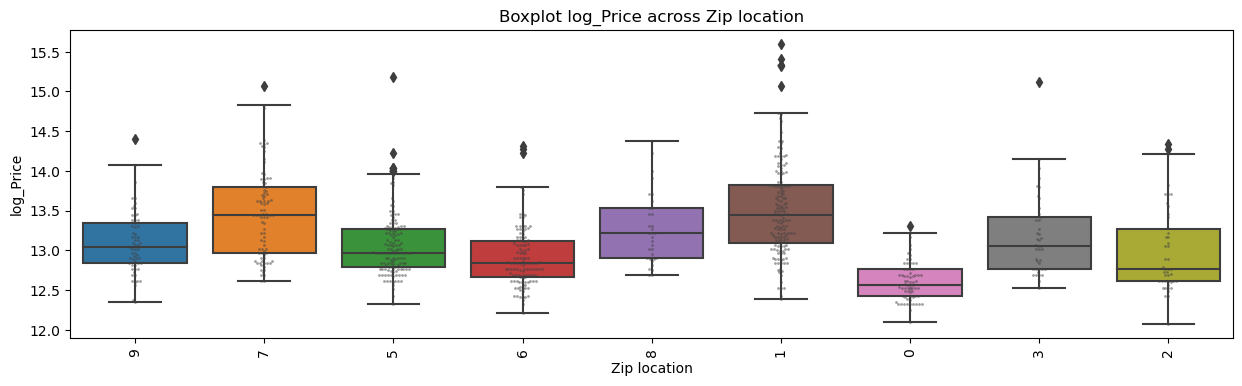

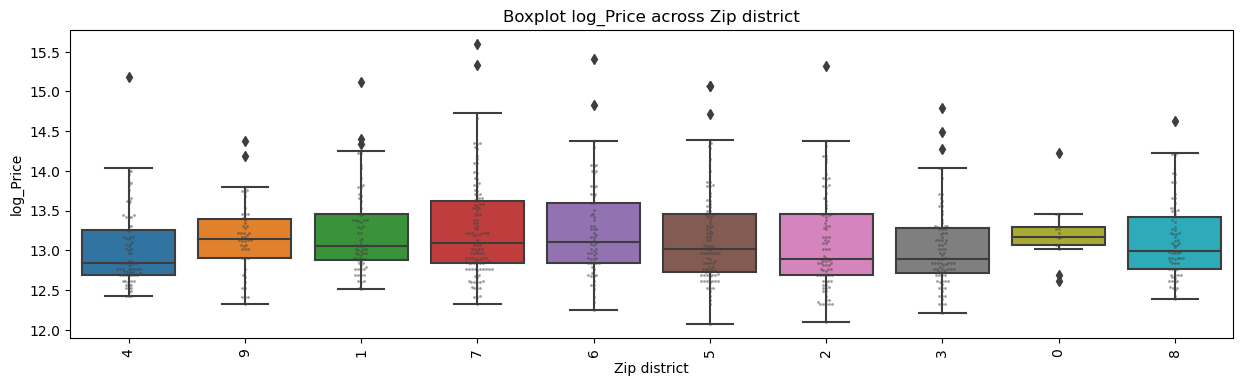

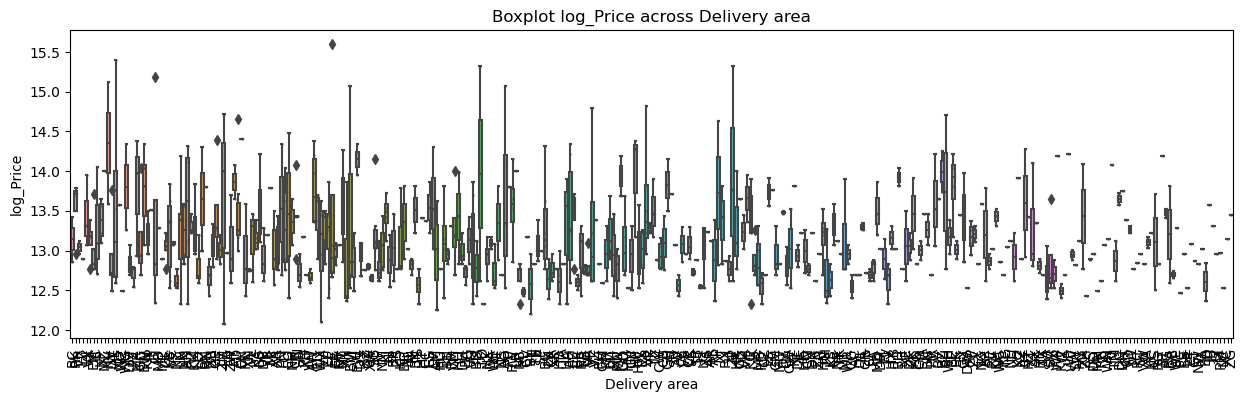

In [32]:
anova_df = pd.DataFrame()
anova_df = custom_anova(data1, ['Zip region', 'Zip location', 'Zip district', 'Delivery area'], 'log_Price', anova_df)
anova_df

The analysis says that the Zip region and Zip location are statistically signifficant. However, if one take a look at the Zip location boxplot, one can find out that the groups are barely different. So, it only makes sence to have Zip region, which is binary and simply means if the house is located in Zuid-ost (1) or in any other district of Amsterdam (0).

**Option 2:** Nevertheless, if one is attentive enough, one could notice that according to the [city map](https://slotenmaker365-amsterdam.nl/wp-content/uploads/2018/04/map-amsterdam.png) the 3rd and 4th digits together create a unique number. It always starts with 0 for Zuid-oost and with 1-9 for the rest of the city. And the bigger this number is, the futher from the city center is the house. This assumption is the next one to be checked:

In [33]:
data1['Zip new'] = data1['Zip location']+data1['Zip district']
data1 = data1.drop(columns=['Zip location', 'Zip district', 'Delivery area'])
data1.sample()

,Zip,Price,Area,Price per sqm,log_Price,log_Area,Manhattan_distance,Zip region,Zip new
368,1016 EH,995000.0,97,10257.731959,13.810498,4.574711,0.011091,0,16


/Users/nadiiaduiunova/miniconda3/envs/to_remove/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


,test-type,feature,group-var,f-value,p-value,stat-sign,variances
0,Welch ANOVA,Zip region,log_Price,277.171,0.00000,True,not_equal
1,Welch ANOVA,Zip location,log_Price,46.355,0.00000,True,not_equal
2,One way ANOVA,Zip district,log_Price,1.460,0.15864,False,equal
3,One way ANOVA,Delivery area,log_Price,0.711,0.99934,False,equal
4,Welch ANOVA,Zip new,log_Price,8.029,0.00000,True,not_equal


/Users/nadiiaduiunova/miniconda3/envs/to_remove/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


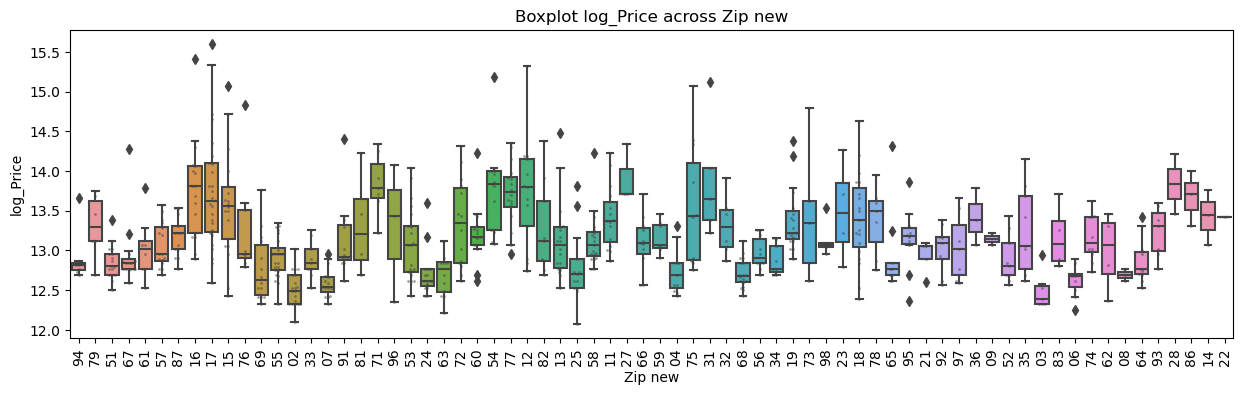

In [34]:
anova_df = custom_anova(data = data1, grouping_var = ['Zip new'], feature='log_Price', result_table=anova_df)
anova_df

Even though the ANOVA analysis says that is a statistically significant feature, there are still too many groups, and some of them have really little observations, while some have a huge inside-the-group variance.

In [35]:
data1 = data1.drop(columns=['Zip new'])

**Option 3:** There is one more possibility: to cluster zip codes by the city districts. There are [8 districts](https://www.amsterdamsights.com/maps/districts.jpg) in Amsterdam: 
Centrum, Noord, West, Zuid, Oost, Nieuw-West, Westpoort (non-residential area), and Zuidoost. Let's cluster the Zips manualy to these districts:

In [36]:
# to define the district, we only need the number part of the Zip code

for row in range(data1.shape[0]):
    data1.loc[row, 'Zip num'] = str(data.loc[row, 'Zip'][:4])

data1 = data1.drop(columns=['Zip'])

data1.sample()

,Price,Area,Price per sqm,log_Price,log_Area,Manhattan_distance,Zip region,Zip num
703,430000.0,103,4174.757282,12.97154,4.634729,0.082814,0,1068


In [37]:
# first version of possible clustering
data1['District_v1'] = 'undefined'

data1.loc[
        lambda x: x["Zip num"].isin(['1011', '1012', '1015', '1016', '1017', '1018']), "District_v1"
    ] = "Centrum"

data1.loc[
        lambda x: x["Zip num"].isin(['1021', '1022', '1023', '1024', '1025', '1026', '1027', '1028', '1029', '1031', '1032', '1033', '1034', '1035', '1036']), "District_v1"
    ] = "Noord"

data1.loc[
        lambda x: x["Zip num"].isin(['1013', '1014', '1051', '1052', '1053', '1054', '1055', '1056', '1057']), "District_v1"
    ] = "West"

data1.loc[
        lambda x: x["Zip num"].isin(['1058', '1059', '1071', '1072', '1073', '1074', '1075', '1076', '1077', '1078', '1079', '1081', '1082', '1083']), "District_v1"
    ] = "Zuid"

data1.loc[
        lambda x: x["Zip num"].isin(['1019', '1086', '1087', '1091', '1092', '1093', '1094', '1095', '1096', '1097', '1098']), "District_v1"
    ] = "Oost"

data1.loc[
        lambda x: x["Zip num"].isin(['1060', '1061', '1062', '1063', '1064', '1065', '1066', '1067', '1068', '1069']), "District_v1"
    ] = "Nieuw-West"

data1.loc[
        lambda x: x["Zip num"].isin(['1101', '1102', '1103', '1104', '1105', '1104', '1105', '1106', '1107', '1108', '1109']), "District_v1"
    ] = "Zuid-Oost"


In [38]:
# make sure each observation belongs to one of the groups
data1['District_v1'].value_counts()

District_v1
West          131
Zuid          128
Nieuw-West    120
Centrum       108
Oost           96
Noord          85
Zuid-Oost      69
Name: count, dtype: int64

,test-type,feature,group-var,f-value,p-value,stat-sign,variances
0,Welch ANOVA,Zip region,log_Price,277.171,0.00000,True,not_equal
1,Welch ANOVA,Zip location,log_Price,46.355,0.00000,True,not_equal
2,One way ANOVA,Zip district,log_Price,1.460,0.15864,False,equal
3,One way ANOVA,Delivery area,log_Price,0.711,0.99934,False,equal
4,Welch ANOVA,Zip new,log_Price,8.029,0.00000,True,not_equal
5,Welch ANOVA,District_v1,log_Price,61.974,0.00000,True,not_equal


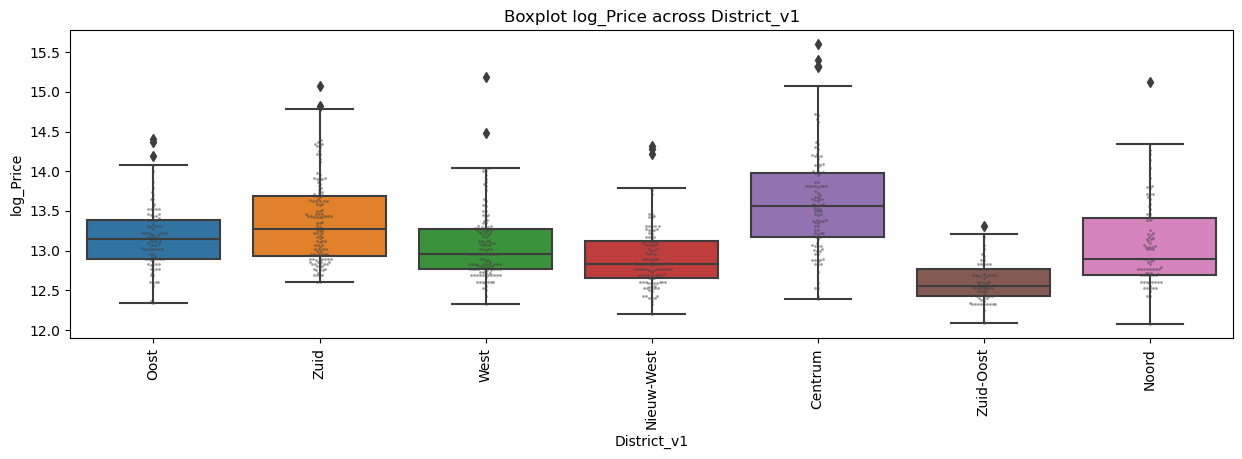

In [39]:
anova_df = custom_anova(data=data1, grouping_var=['District_v1'], feature='log_Price', result_table=anova_df)
anova_df

Let's analyze the plot: Centrum and Zuid are pretty simmilar, also Oost, West, Nieuw-West and Noord could be clustered together. So we'll now have 3 clusters: Centrum+Zuid, Zuid-Oost, and the rest

In [40]:
# clustering a new way
data1['District_v2'] = ''

data1.loc[
        lambda x: x["District_v1"].isin(['Centrum', 'Zuid']), "District_v2"
    ] = "Centrum+Zuid"

data1.loc[
        lambda x: x["District_v1"].isin(['Noord', 'West', 'Oost', 'Nieuw-West']), "District_v2"
    ] = "the_rest"

data1.loc[
        lambda x: x["District_v1"].isin(['Zuid-Oost']), "District_v2"
    ] = "Zuid-Oost"


,test-type,feature,group-var,f-value,p-value,stat-sign,variances
0,Welch ANOVA,Zip region,log_Price,277.171,0.00000,True,not_equal
1,Welch ANOVA,Zip location,log_Price,46.355,0.00000,True,not_equal
2,One way ANOVA,Zip district,log_Price,1.460,0.15864,False,equal
3,One way ANOVA,Delivery area,log_Price,0.711,0.99934,False,equal
4,Welch ANOVA,Zip new,log_Price,8.029,0.00000,True,not_equal
5,Welch ANOVA,District_v1,log_Price,61.974,0.00000,True,not_equal
6,Welch ANOVA,District_v2,log_Price,171.200,0.00000,True,not_equal


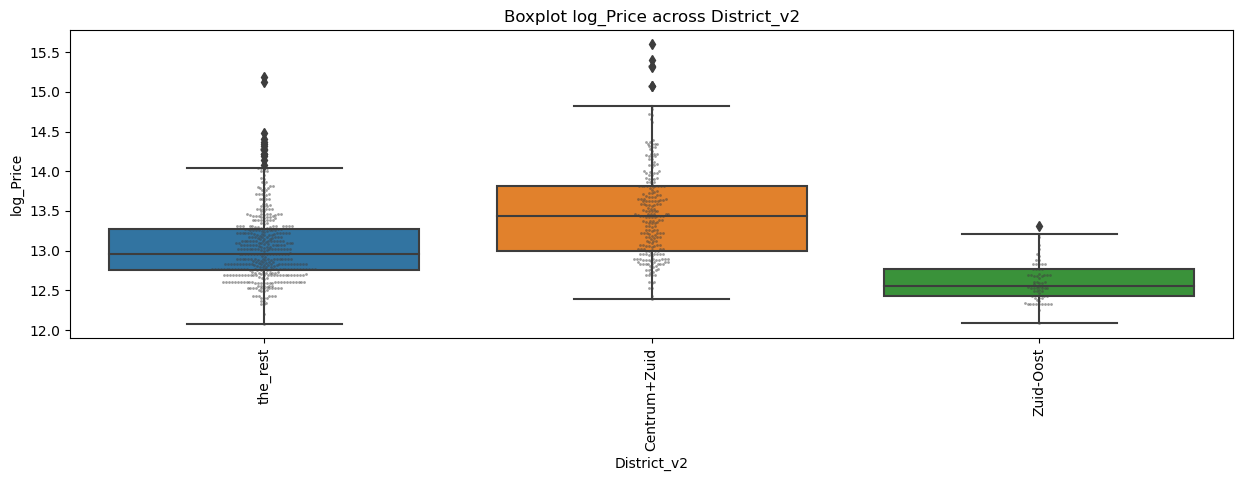

In [41]:
anova_df = custom_anova(data=data1, grouping_var=['District_v2'], feature='log_Price', result_table=anova_df)
anova_df

These groups look more different than the previous ones. The p-value is still very close to 0, so this could be a good clustering. There is also a possibility to change the target to price per square meter, but that will be done later, not for a benchmark model.

**4. Create a benchmark model**

Let's create an initial model and measure the benchmark accuracy. The model will require text data transformation and scaling of numerical features:
 1. Address wil be removed as it is unique for every datapoint, so has no predictive power
 2. Zip code will be cut to just numbers and checked if it is correlated with target (every digit in the Zip code has its own meaning, so instead of 1 feature there would be 4)
 3. Price, Area and Room features will be normalized.

**Option 1:** 
- logarithm of Price
- logarithm of Area
- Manhattan distance
- one-hot-encoded District_v2, as it showed better correlation with the target

In [42]:
data1.sample()

,Price,Area,Price per sqm,log_Price,log_Area,Manhattan_distance,Zip region,Zip num,District_v1,District_v2
238,725000.0,87,8333.333333,13.493927,4.465908,0.028232,0,1015,Centrum,Centrum+Zuid


In [43]:
# 1. remove extra or unimportant columns

df = data1.drop(columns=['Price', 'Area', 'Price per sqm', 'Zip region', 'Zip num', 'District_v1'])
df.sample()

,log_Price,log_Area,Manhattan_distance,District_v2
506,13.976779,5.068904,0.029887,Centrum+Zuid


In [44]:
correlations_df, _ = custom_corr(df, data_info, features=['log_Price', 'log_Area', 'Manhattan_distance'])
correlations_df

,method,feature1,feature2,r-value,p-value,stat-sign,N
0,Spearman,log_Price,log_Area,0.720851,3.896903e-119,True,737
1,Spearman,log_Price,Manhattan_distance,-0.462796,2.149184e-40,True,737
2,Spearman,log_Area,Manhattan_distance,0.072879,4.795577e-02,True,737


According to correlation matrix, the data is ready to be fed to the initial model to get benchmark accuracy. But first the `District` feature has to be one hot encoded:

In [45]:
district = pd.get_dummies(df['District_v2'], drop_first=True, dtype=int, prefix='District')
df = pd.concat([df, district], axis = 1)
df.sample()

,log_Price,log_Area,Manhattan_distance,District_v2,District_Zuid-Oost,District_the_rest
98,13.122363,4.454347,0.057948,the_rest,0,1


In [46]:
X1 = df.drop(columns=['log_Price', 'District_v2'])
y1 = df['log_Price']

model1 = LinearRegression()

In [47]:
results = pd.DataFrame()
results['Model'] = ''
results['List of used features'] = []
results['RMSE_train'] = np.nan
results['RMSE_valid'] = np.nan
results['MAE_train'] = np.nan
results['MAE_valid'] = np.nan
results['r2_train'] = np.nan
results['r2_valid'] = np.nan
results['expl_variance_train'] = np.nan
results['expl_variance_valid'] = np.nan
results['corr_coef_train'] = np.nan
results['corr_coef_valid'] = np.nan
results['VIFs'] = []

In [48]:
evaluate_model(model1, X1, y1, results, cv = 4)
results

,Model,List of used features,RMSE_train,RMSE_valid,MAE_train,MAE_valid,r2_train,r2_valid,expl_variance_train,expl_variance_valid,corr_coef_train,corr_coef_valid,VIFs
0,LinearRegression(),"[log_Area, Manhattan_distance, District_Zuid-O...",191407,271648,102272,102456,0.850789,0.788447,0.851855,0.79403,0.9063,0.924577,"[4.35, 8.22, 3.23, 4.0]"


This model is no good. There is almost 250k error in price, which is quite a lot. ALso Manhattan_distance shows high VIF value, which means ir is correlated with other features.

**Option 2:** 
- logarithm of Price
- logarithm of Area
- Manhattan distance
- one-hot-encoded District_v1, to see if it could work better

In [49]:
data1.sample()

,Price,Area,Price per sqm,log_Price,log_Area,Manhattan_distance,Zip region,Zip num,District_v1,District_v2
87,1149000.0,141,8148.93617,13.954403,4.94876,0.017641,0,1078,Zuid,Centrum+Zuid


In [50]:
df = data1.drop(columns=['Price', 'Area', 'Price per sqm', 'Zip region', 'Zip num', 'District_v2'])
df.sample()

,log_Price,log_Area,Manhattan_distance,District_v1
373,12.765688,4.70048,0.077427,Noord


In [51]:
district = pd.get_dummies(df['District_v1'], drop_first=True, dtype=int, prefix='District')
df = pd.concat([df, district], axis = 1)
df.sample()

,log_Price,log_Area,Manhattan_distance,District_v1,District_Nieuw-West,District_Noord,District_Oost,District_West,District_Zuid,District_Zuid-Oost
237,13.592367,4.812184,0.015389,Zuid,0,0,0,0,1,0


In [52]:
X2 = df.drop(columns=['log_Price', 'District_v1'])
y2 = df['log_Price']

model2 = LinearRegression()

In [53]:
evaluate_model(model2, X2, y2, results, cv = 4)
results

,Model,List of used features,RMSE_train,RMSE_valid,MAE_train,MAE_valid,r2_train,r2_valid,expl_variance_train,expl_variance_valid,corr_coef_train,corr_coef_valid,VIFs
0,LinearRegression(),"[log_Area, Manhattan_distance, District_Zuid-O...",191407,271648,102272,102456,0.850789,0.788447,0.851855,0.794030,0.9063,0.924577,"[4.35, 8.22, 3.23, 4.0]"
1,LinearRegression(),"[log_Area, Manhattan_distance, District_Nieuw-...",197704,270236,93104,92048,0.869028,0.790640,0.869805,0.796803,0.9217,0.947081,"[6.06, 14.59, 3.84, 3.59, 1.98, 2.09, 2.04, 5.33]"


Some parameters have been improved, however the VIF values are now worse: not only `Manhattan distance` leads to multicollinearuty, but also `Area`

**Option 3:** 
- logarithm of Price
- logarithm of Area
- Zip region
- one-hot-encoded District_v2, as it has lower VIFs

In [54]:
df = data1.drop(columns=['Price', 'Area', 'Price per sqm', 'Zip num', 'District_v1'])
df.sample()

,log_Price,log_Area,Manhattan_distance,Zip region,District_v2
99,13.279367,4.317488,0.038251,0,the_rest


In [55]:
region = pd.get_dummies(df['Zip region'], drop_first=True, dtype=int, prefix='Region')
district = pd.get_dummies(df['District_v2'], drop_first=True, dtype=int, prefix='District')
df = pd.concat([df, region, district], axis = 1)
df.sample()

,log_Price,log_Area,Manhattan_distance,Zip region,District_v2,Region_1,District_Zuid-Oost,District_the_rest
607,13.345507,4.304065,0.013855,0,Centrum+Zuid,0,0,0


In [56]:
X3 = df.drop(columns=['log_Price', 'Zip region', 'District_v2'])
y3 = df['log_Price']

model3 = LinearRegression()

In [57]:
evaluate_model(model3, X3, y3, results, cv = 4)
results

/Users/nadiiaduiunova/miniconda3/envs/to_remove/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Model,List of used features,RMSE_train,RMSE_valid,MAE_train,MAE_valid,r2_train,r2_valid,expl_variance_train,expl_variance_valid,corr_coef_train,corr_coef_valid,VIFs
0,LinearRegression(),"[log_Area, Manhattan_distance, District_Zuid-O...",191407,271648,102272,102456,0.850789,0.788447,0.851855,0.794030,0.9063,0.924577,"[4.35, 8.22, 3.23, 4.0]"
1,LinearRegression(),"[log_Area, Manhattan_distance, District_Nieuw-...",197704,270236,93104,92048,0.869028,0.790640,0.869805,0.796803,0.9217,0.947081,"[6.06, 14.59, 3.84, 3.59, 1.98, 2.09, 2.04, 5.33]"
2,LinearRegression(),"[log_Area, Manhattan_distance, Region_1, Distr...",233789,271648,108540,102456,0.850789,0.788447,0.851855,0.794030,0.9013,0.924577,"[3.79, 8.13, inf, inf, 4.03]"


It is obvious, that using both region and district is a bad idea. Let's now try to remove district

**Option 4:** 
- logarithm of Price
- logarithm of Area
- Zip region

In [58]:
df = data1.drop(columns=['Price', 'Area', 'Price per sqm', 'Zip num', 'District_v1', 'District_v2'])

In [59]:
region = pd.get_dummies(df['Zip region'], drop_first=True, dtype=int, prefix='Region')
df = pd.concat([df, region], axis = 1)
df.sample()

,log_Price,log_Area,Manhattan_distance,Zip region,Region_1
685,14.301018,5.293305,0.015783,0,0


In [60]:
X4 = df.drop(columns=['log_Price', 'Zip region'])
y4 = df['log_Price']
model4 = LinearRegression()

In [61]:
evaluate_model(model4, X4, y4, results, cv = 4)
results

,Model,List of used features,RMSE_train,RMSE_valid,MAE_train,MAE_valid,r2_train,r2_valid,expl_variance_train,expl_variance_valid,corr_coef_train,corr_coef_valid,VIFs
0,LinearRegression(),"[log_Area, Manhattan_distance, District_Zuid-O...",191407,271648,102272,102456,0.850789,0.788447,0.851855,0.794030,0.9063,0.924577,"[4.35, 8.22, 3.23, 4.0]"
1,LinearRegression(),"[log_Area, Manhattan_distance, District_Nieuw-...",197704,270236,93104,92048,0.869028,0.790640,0.869805,0.796803,0.9217,0.947081,"[6.06, 14.59, 3.84, 3.59, 1.98, 2.09, 2.04, 5.33]"
2,LinearRegression(),"[log_Area, Manhattan_distance, Region_1, Distr...",233789,271648,108540,102456,0.850789,0.788447,0.851855,0.794030,0.9013,0.924577,"[3.79, 8.13, inf, inf, 4.03]"
3,LinearRegression(),"[log_Area, Manhattan_distance, Region_1]",253703,272621,109130,101860,0.846804,0.786928,0.847811,0.792099,0.9122,0.920842,"[4.18, 6.39, 2.23]"


The first model seems to perform as good as others, but has the lowest VIFs. Let's try to remove Manhattan_distance from it and run the evaluation function again:

**Option 5:** 
- logarithm of Price
- logarithm of Area
- one-hot-encoded District_v2

In [62]:
X5 = X1.copy().drop(columns=['Manhattan_distance'])
y5 = y1
model5 = LinearRegression()

In [63]:
evaluate_model(model5, X5, y5, results, cv = 4)
results

,Model,List of used features,RMSE_train,RMSE_valid,MAE_train,MAE_valid,r2_train,r2_valid,expl_variance_train,expl_variance_valid,corr_coef_train,corr_coef_valid,VIFs
0,LinearRegression(),"[log_Area, Manhattan_distance, District_Zuid-O...",191407,271648,102272,102456,0.850789,0.788447,0.851855,0.794030,0.9063,0.924577,"[4.35, 8.22, 3.23, 4.0]"
1,LinearRegression(),"[log_Area, Manhattan_distance, District_Nieuw-...",197704,270236,93104,92048,0.869028,0.790640,0.869805,0.796803,0.9217,0.947081,"[6.06, 14.59, 3.84, 3.59, 1.98, 2.09, 2.04, 5.33]"
2,LinearRegression(),"[log_Area, Manhattan_distance, Region_1, Distr...",233789,271648,108540,102456,0.850789,0.788447,0.851855,0.794030,0.9013,0.924577,"[3.79, 8.13, inf, inf, 4.03]"
3,LinearRegression(),"[log_Area, Manhattan_distance, Region_1]",253703,272621,109130,101860,0.846804,0.786928,0.847811,0.792099,0.9122,0.920842,"[4.18, 6.39, 2.23]"
4,LinearRegression(),"[log_Area, District_Zuid-Oost, District_the_rest]",268069,335543,132765,137928,0.782330,0.677223,0.783123,0.687628,0.8673,0.858843,"[3.2, 1.29, 2.9]"


**Option 6:** 
- logarithm of Price
- logarithm of Area
- Manhattan distance

In [64]:
X6 = X4.copy().drop(columns=['Region_1'])
y6 = y4
model6 = LinearRegression()

In [65]:
evaluate_model(model6, X6, y6, results, cv = 4)
results

,Model,List of used features,RMSE_train,RMSE_valid,MAE_train,MAE_valid,r2_train,r2_valid,expl_variance_train,expl_variance_valid,corr_coef_train,corr_coef_valid,VIFs
0,LinearRegression(),"[log_Area, Manhattan_distance, District_Zuid-O...",191407,271648,102272,102456,0.850789,0.788447,0.851855,0.794030,0.9063,0.924577,"[4.35, 8.22, 3.23, 4.0]"
1,LinearRegression(),"[log_Area, Manhattan_distance, District_Nieuw-...",197704,270236,93104,92048,0.869028,0.790640,0.869805,0.796803,0.9217,0.947081,"[6.06, 14.59, 3.84, 3.59, 1.98, 2.09, 2.04, 5.33]"
2,LinearRegression(),"[log_Area, Manhattan_distance, Region_1, Distr...",233789,271648,108540,102456,0.850789,0.788447,0.851855,0.794030,0.9013,0.924577,"[3.79, 8.13, inf, inf, 4.03]"
3,LinearRegression(),"[log_Area, Manhattan_distance, Region_1]",253703,272621,109130,101860,0.846804,0.786928,0.847811,0.792099,0.9122,0.920842,"[4.18, 6.39, 2.23]"
4,LinearRegression(),"[log_Area, District_Zuid-Oost, District_the_rest]",268069,335543,132765,137928,0.782330,0.677223,0.783123,0.687628,0.8673,0.858843,"[3.2, 1.29, 2.9]"
5,LinearRegression(),"[log_Area, Manhattan_distance]",176844,269732,97956,101547,0.846360,0.791421,0.847387,0.796526,0.9123,0.921296,"[3.34, 3.34]"


Even though the RMSE is still very high, the features in models 5 and 6 do not have multicollinearity according to low VIF values. The **last model has better scalability**, because Manhattan_distance feature is much easier to develop in case if model will be expanded to other cities. Most of metrics are better here too. We will try to develop this model in the 'Machine learning' part.

In [66]:
# save all the dataframes for futher use

results.to_csv("./data/results.csv", index=False)
data_info.to_parquet("./data/data_info.parquet")
data1.to_csv("./data/data_train.csv", index=False)

## Summary:


1. Area and Room features are correlated, so Area-Room ratio was created instead, however showed no improvement in correlation analysis.
2. Lon, Lat, Address have no impact on target.
3. 'Distance' feature was created out of Lon and Lat. The Manhattan distance showed better performance than Euclidean and Haversine distances.
4. The whole Zip code has no influence on the target as well. However, it is possible to define the district out of Zip code, which is more predictive.
5. Price per square meter could be an alternative target. This assumption still requires a proof.
6. There could be improvement of model's ability to predict if we cut the maximum price to 1-2M.
7. The best set of features so far is: logarithm of 'Area' and one-hot-encoded 'District_v2', which is 'District_Zuid-Oost', 'District_the_rest' and 'Centrum+Zuid', because this set showed thi lowest VIF values.